In [43]:
# %load data_preparation/v4.py
# Removes the one-hot encoding as a step performed on xs
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

# create a classifier class that inherits from nn.Module
class BigramClassifier(torch.nn.Module):
    def __init__(self):
        super(BigramClassifier, self).__init__()
        self.W = torch.nn.Parameter(torch.randn((27,27), generator=g, requires_grad=True))

    # x here is no longer a one-hot encoded vector, instead we must select the row of W that corresponds to the index of the letter
    def forward(self, x):
        return self.W[x]


device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f'Device: {device}')

g = torch.Generator().manual_seed(42)

words = open('names.txt').read().splitlines()
letters = sorted(list(set(''.join(words))))
letter_to_index = {letter: index for index, letter in enumerate(letters)}
letter_to_index['.'] = 0
index_to_letter = {i: letter for letter, i in letter_to_index.items()}

xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(letter_to_index[ch1])
        ys.append(letter_to_index[ch2])

xs = torch.as_tensor(xs)
ys = torch.as_tensor(ys)

dataset = TensorDataset(xs, ys)

train_ratio = .8
validation_ratio = .1

n_total = len(dataset)
n_train = int(n_total * train_ratio)
n_train_batch=n_train
n_validation = int(n_total * validation_ratio)
n_validation_batch=n_validation
n_test = n_total - n_train - n_validation

train_data, validation_data, test_data = random_split(dataset, [n_train, n_validation, n_test])

train_loader = DataLoader(train_data, batch_size=n_train_batch, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=n_validation_batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=n_test, shuffle=True)


Device: mps


In [45]:
# %load model_configuration/v2.py
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

def smoothing():
    return + 0.01*(model.W**2).mean()

def make_train_step_fn(model, loss_fn, optimizer):
    def train_step(x, y):
        
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y) + smoothing()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
    return train_step

# make a validation step function
def make_validation_step_fn(model, loss_fn):
    def validation_step(x, y):
        model.eval()
        # NO GRADIENTS IN VALIDATION
        with torch.no_grad():
            yhat = model(x)
            loss = loss_fn(yhat, y)
            return loss.item()
    return validation_step

lr = 50
momentum = 0.9
model = BigramClassifier()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_fn = torch.nn.CrossEntropyLoss()

train_step_fn = make_train_step_fn(model, loss_fn, optimizer)
validation_step_fn = make_validation_step_fn(model, loss_fn)

writer = SummaryWriter('runs/bigram_classifier')
x_dummy, y_dummy = next(iter(train_loader))
#writer.add_graph(model, x_dummy.to(device))

In [46]:
# %load model_training/v4.py
import torch
import torch.nn.functional as F
import numpy

epochs = 50
losses = []

def mini_batch(device, data_loader, stepn_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        loss = stepn_fn(x_batch, y_batch)
        mini_batch_losses.append(loss)
    return numpy.mean(mini_batch_losses)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

    writer.add_scalars(main_tag=f'MPS&lr={lr}&momentum={momentum}&epochs={epochs}&batch={n_train_batch}&smoothing=0.01', tag_scalar_dict={'training': loss}, global_step=epoch)

writer.close()

checkpoint = {
    'epoch': epochs,
    'lr': lr,
    'momentum': momentum,
    'smoothing': '0.01+W**2.mean()',
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses
}

torch.save(checkpoint, 'checkpoint.pth')
# print last losses value
print(f'Final training loss: {losses[-1]}')

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Final training loss: 3.1924378871917725


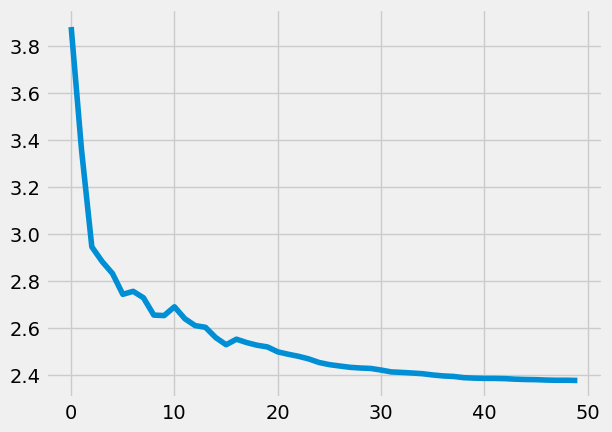

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.plot(losses)

In [32]:
# What version of Python do you have?
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-10.16-x86_64-i386-64bit
PyTorch Version: 1.13.0

Python 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
Pandas 1.4.4
Scikit-Learn 1.0.2
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps
